In [1]:

from __future__ import division
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from pybasicbayes.distributions import Regression
from pybasicbayes.util.text import progprint_xrange
from autoregressive.distributions import AutoRegression

import pyximport
pyximport.install()
import os
os.chdir('../pylds')
from models import LDS, DefaultLDS
from distributions import Regression_diag, AutoRegression_input
from obs_scheme import ObservationScheme
from user_util import gen_pars, rand_rotation_matrix, init_LDS_model, collect_LDS_stats
#npr.seed(0)

def update(model):
    model.EM_step()
    return model.log_likelihood()                    

#########################
#  set some parameters  #
#########################

n = 10
p = 1000
T = 10000


pars_true, _ = gen_pars(n, p, u_dim=0, 
             pars_in=None, 
             obs_scheme=None,
             gen_A='diagonal', lts=np.linspace(0.95, 0.98, n),
             gen_B='random', 
             gen_Q='identity', 
             gen_mu0='random', 
             gen_V0='identity', 
             gen_C='random', 
             gen_d='scaled', 
             gen_R='fraction',
             diag_R_flag=True,
             x=None, y=None, u=None)

sub_pops = (np.arange(0, p//2 + 2), np.arange(p//2 - 2, p))
obs_pops = np.array((0,1))
obs_time = np.array((T//2,T))
obs_scheme = ObservationScheme(p, T, sub_pops, obs_pops, obs_time)

###################
#  generate data  #
###################

truemodel = LDS(
    dynamics_distn=AutoRegression(A=pars_true['A'].copy(),sigma=pars_true['Q'].copy()),
    emission_distn=Regression_diag(A=np.hstack((pars_true['C'].copy(), pars_true['d'].copy().reshape(p,1))),
                                   sigma=pars_true['R'].copy(), affine=True),
                )
truemodel.mu_init = pars_true['mu0'].copy()
truemodel.sigma_init = pars_true['V0'].copy()

data, stateseq = truemodel.generate(T)


###################
#    EM cycles    #
###################

pars_init, _ = gen_pars(n, p, u_dim=0, 
                     pars_in=None, 
                     obs_scheme=obs_scheme,
                     gen_A='diagonal', lts=0.99 * np.ones((n,)),
                     gen_B='random', 
                     gen_Q='identity', 
                     gen_mu0='random', 
                     gen_V0='identity', 
                     gen_C='PCA_subpop', 
                     gen_d='mean', 
                     gen_R='fractionObserved',
                     diag_R_flag=True,
                     x=stateseq.T, y=data.T, u=None)


# get E-step results for init pars
model = init_LDS_model(pars_init, data, obs_scheme) # set to initialisation
model.E_step()
stats_init,_ = collect_LDS_stats(model)

# get EM-step results after one iteration
model.M_step()
model.E_step()
stats_first,pars_first = collect_LDS_stats(model)

# get EM-step results after 50 iterations                    
model = init_LDS_model(pars_init, data, obs_scheme) # reset to initialisation                    
print 'fitting'
likes = [update(model) for _ in progprint_xrange(300)]
stats_hat,pars_hat = collect_LDS_stats(model)
                                                        
# get EM-step results from true parameters
model = init_LDS_model(pars_true, data, obs_scheme) # reset to true pars
model.E_step()
stats_true,_ = collect_LDS_stats(model)
model.M_step()                                        

###################
#  store results  #
###################

save_file = '../../../results/pylds_debug/' + 'pylds_1x2_diag'
from scipy.io import savemat # store results for comparison with Matlab code   
from scipy.linalg import solve_discrete_lyapunov as dtlyap # solve discrete-time Lyapunov equation
save_file_m = {'x': model.states_list[0].stateseq, 
               'y': model.states_list[0].data,
               'u' : [], 
               'll' : likes, 
               'T' : model.states_list[0].T, 
               'Trial': len(model.states_list), 
               'elapsedTime' : 0,
               'ifUseB':False, 
               'ifUseA':True, 
               'epsilon':0,
               'ifRDiagonal':False,
               'covConvEps':0,        
               'truePars':pars_true,
               'initPars':pars_init,
               'firstPars':pars_first,
               'estPars': pars_hat,
               'stats_0': stats_init,
               'stats_1': stats_first,
               'stats_h': stats_hat,
               'stats_true': stats_true,
               'Pi':dtlyap(pars_true['A'], pars_true['Q']),
               'Pi_h':dtlyap(pars_hat['A'], pars_hat['Q']),
               'Pi_t':pars_true['A'].dot(dtlyap(pars_true['A'], pars_true['Q'])),
               'Pi_t_h':pars_hat['A'].dot(dtlyap(pars_hat['A'], pars_hat['Q'])),
               'obsScheme' : []}

savemat(save_file,save_file_m) # does the actual saving


fitting
.........................  [  25/300,    3.84sec avg, ETA 17:36 ]
.........................  [  50/300,    3.90sec avg, ETA 16:15 ]
.........................  [  75/300,    3.86sec avg, ETA 14:29 ]
.........................  [ 100/300,    3.81sec avg, ETA 12:42 ]
.........................  [ 125/300,    3.81sec avg, ETA 11:06 ]
.........................  [ 150/300,    3.79sec avg, ETA 09:28 ]
.........................  [ 175/300,    3.80sec avg, ETA 07:54 ]
.........................  [ 200/300,    3.77sec avg, ETA 06:17 ]
.........................  [ 225/300,    3.73sec avg, ETA 04:40 ]
.........................  [ 250/300,    3.74sec avg, ETA 03:07 ]
.........................  [ 275/300,    3.75sec avg, ETA 01:34 ]
.........................  [ 300/300,    3.74sec avg, ETA 0.00 ]

   3.74sec avg, 18:42 total



/home/mackelab/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


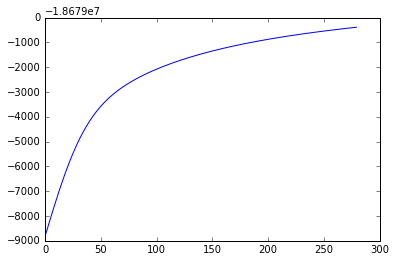

In [2]:
%matplotlib inline
plt.plot(likes[20:])
plt.show()

/home/mackelab/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


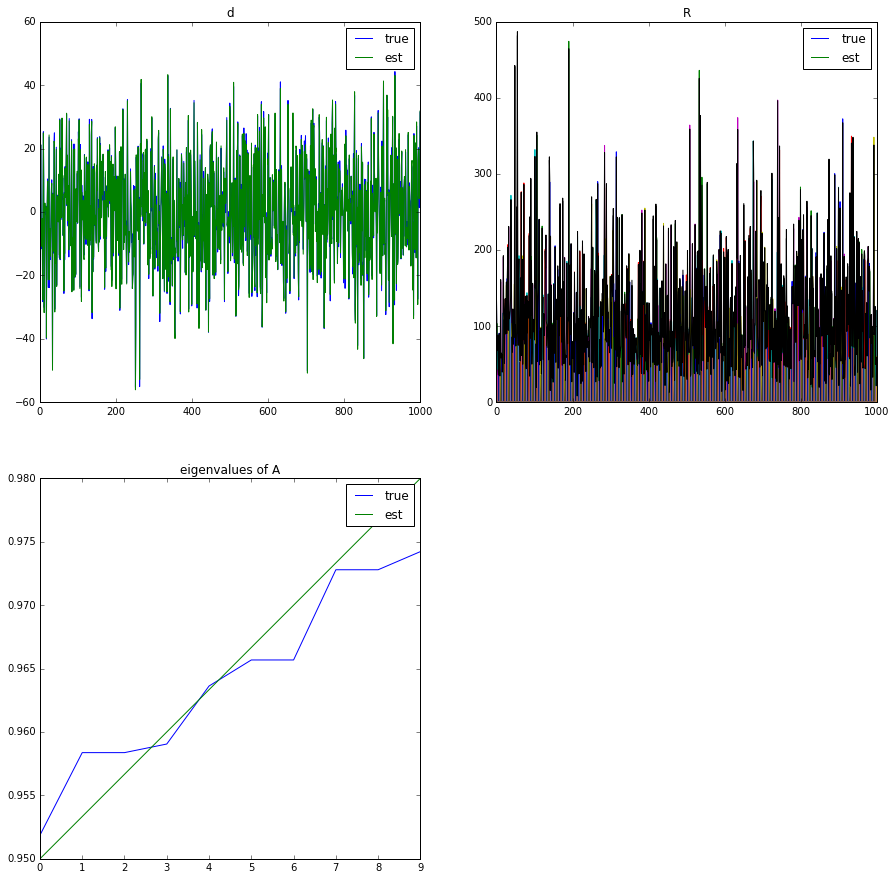

In [3]:
import scipy as sp
import matplotlib.pyplot as plt

Pi = sp.linalg.solve_discrete_lyapunov(pars_hat['A'], pars_hat['Q'])

plt.figure(1,figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow( pars_hat['C'].dot(Pi.dot(pars_hat['C'].transpose())) + pars_hat['R'], 
            interpolation='none')
plt.colorbar()
plt.title('estimated instantaneous covs')
plt.subplot(2,2,2)
Pi_true = sp.linalg.solve_discrete_lyapunov(pars_true['A'], pars_true['Q'])
plt.imshow(pars_true['C'].dot(Pi_true.dot(pars_true['C'].transpose())) + np.diag(pars_true['R']),
           interpolation='none')
plt.colorbar()
plt.title('true instantaneous covs')
plt.subplot(2,2,3)
plt.imshow(pars_hat['C'].dot(pars_hat['A']).dot(Pi.dot(pars_hat['C'].transpose())), 
           interpolation='none' )
plt.colorbar()
plt.title('estimated time-lagged covs')
plt.subplot(2,2,4)
plt.imshow(pars_true['C'].dot(pars_true['A']).dot(Pi_true.dot(pars_true['C'].transpose())), 
          interpolation='none' )
plt.colorbar()
plt.title('true time-lagged covs')

%matplotlib inline
plt.figure(2,figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(pars_hat['d'])
plt.plot(pars_true['d'])
plt.legend(['true', 'est'])
plt.title('d')
plt.subplot(2,2,2)
plt.plot(pars_hat['R'])
plt.plot(pars_true['R'])
plt.legend(['true', 'est'])
plt.title('R')
plt.subplot(2,2,3)
plt.plot(np.sort(np.linalg.eig(pars_hat['A'])[0]))
plt.plot(np.sort(np.linalg.eig(pars_true['A'])[0]))
plt.legend(['true', 'est'])
plt.title('eig(A)')
plt.title('eigenvalues of A')
plt.show()

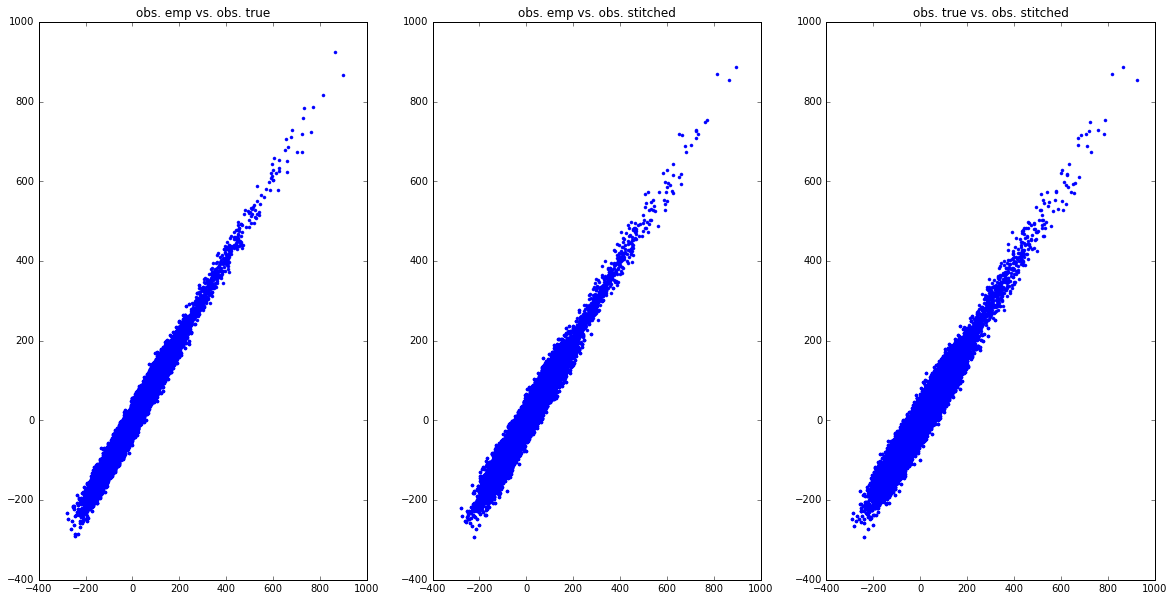

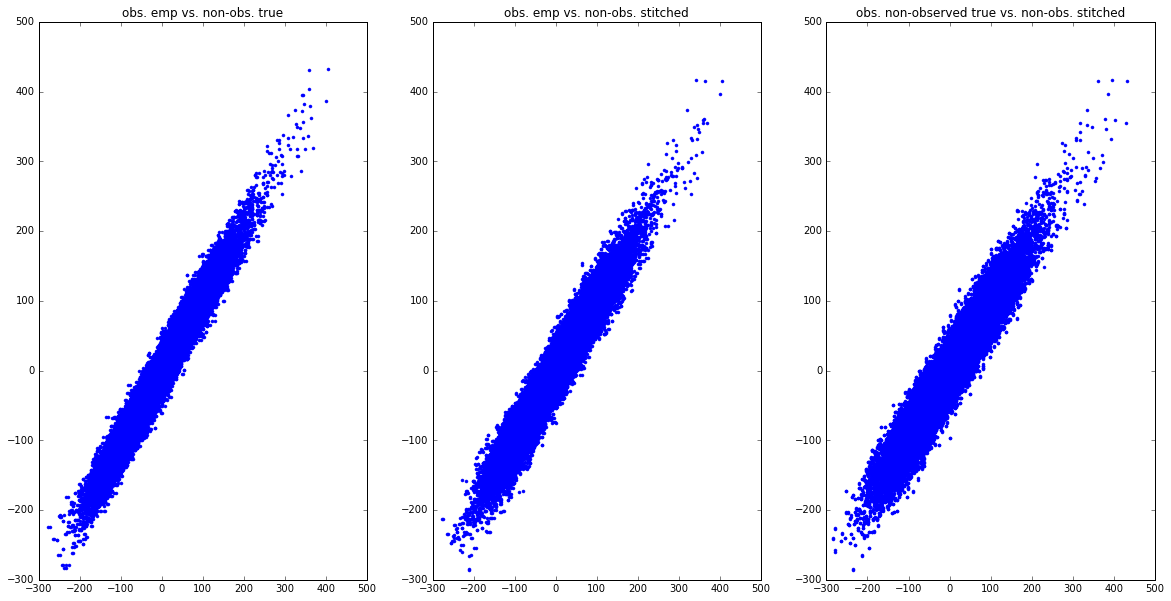

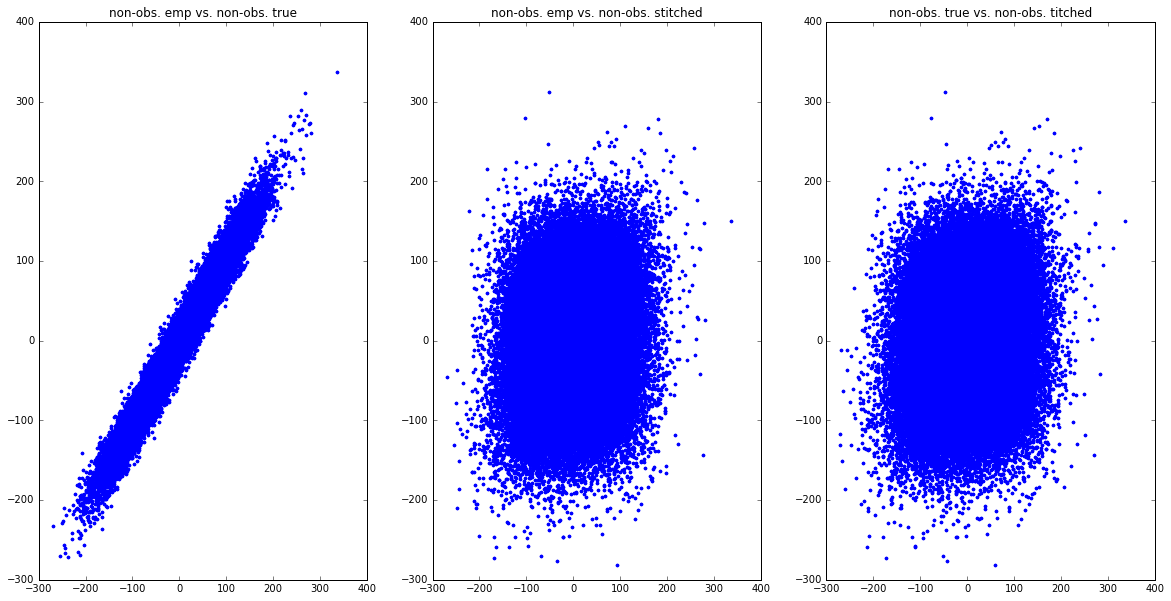

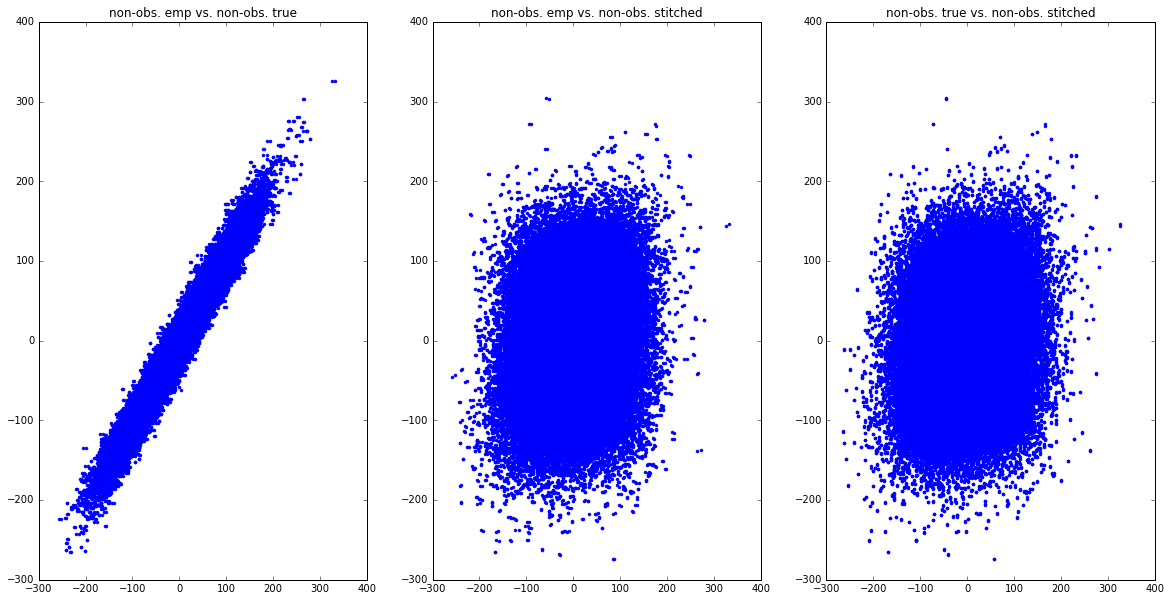

In [4]:
covy_h= np.dot( np.dot(pars_hat['C'], Pi),      pars_hat['C'].transpose()) + pars_hat['R']
covy_t= np.dot(np.dot(pars_true['C'], Pi_true),pars_true['C'].transpose()) + np.diag(pars_true['R'])

y_tl = np.zeros([2*p,T-1])
y_tl[range(p),:] = data[range(0,T-1),:].T
y_tl[range(p,2*p),:] = data[range(1,T),:].T
covy = np.cov(y_tl)

covy_e=    covy[np.ix_(range(p),range(p))]
covy_tl_e= covy[np.ix_(range(p,2*p),range(0,p))]

covy_tl_h= np.dot(np.dot(pars_hat['C'], np.dot(pars_hat['A'],Pi)), pars_hat['C'].transpose())
covy_tl_t=(np.dot(np.dot(pars_true['C'],np.dot(pars_true['A'], Pi_true)),pars_true['C'].transpose()))
%matplotlib inline
idx_stitched = np.ones([p,p],dtype = bool)
for i in range(len(obs_scheme.sub_pops)):
    if len(obs_scheme.sub_pops[i])>0:
        idx_stitched[np.ix_(obs_scheme.sub_pops[i],obs_scheme.sub_pops[i])] = False
plt.imshow(idx_stitched,interpolation='none')

%matplotlib inline
plt.figure(1, figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(covy_e[np.invert(idx_stitched)], covy_t[np.invert(idx_stitched)], '.')
plt.title('obs. emp vs. obs. true')
plt.subplot(1,3,2)
plt.plot(covy_e[np.invert(idx_stitched)], covy_h[np.invert(idx_stitched)], '.')
plt.title('obs. emp vs. obs. stitched')
plt.subplot(1,3,3)
plt.plot(covy_t[np.invert(idx_stitched)], covy_h[np.invert(idx_stitched)], '.')
plt.title('obs. true vs. obs. stitched')

plt.figure(2, figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(covy_tl_e[np.invert(idx_stitched)], covy_tl_t[np.invert(idx_stitched)], '.')
plt.title('obs. emp vs. non-obs. true')
plt.subplot(1,3,2)
plt.plot(covy_tl_e[np.invert(idx_stitched)], covy_tl_h[np.invert(idx_stitched)], '.')
plt.title('obs. emp vs. non-obs. stitched')
plt.subplot(1,3,3)
plt.plot(covy_tl_t[np.invert(idx_stitched)], covy_tl_h[np.invert(idx_stitched)], '.')
plt.title('obs. non-observed true vs. non-obs. stitched')

plt.figure(3, figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(covy_e[idx_stitched], covy_t[idx_stitched], '.')
plt.title('non-obs. emp vs. non-obs. true')
plt.subplot(1,3,2)
plt.plot(covy_e[idx_stitched], covy_h[idx_stitched], '.')
plt.title('non-obs. emp vs. non-obs. stitched')
plt.subplot(1,3,3)
plt.plot(covy_t[idx_stitched], covy_h[idx_stitched], '.')
plt.title('non-obs. true vs. non-obs. titched')

plt.figure(4, figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(covy_tl_e[idx_stitched], covy_tl_t[idx_stitched], '.')
plt.title('non-obs. emp vs. non-obs. true')
plt.subplot(1,3,2)
plt.plot(covy_tl_e[idx_stitched], covy_tl_h[idx_stitched], '.')
plt.title('non-obs. emp vs. non-obs. stitched')
plt.subplot(1,3,3)
plt.plot(covy_tl_t[idx_stitched], covy_tl_h[idx_stitched], '.')
plt.title('non-obs. true vs. non-obs. stitched')